## [1] Amazon ML Text multiclass classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud,STOPWORDS

from collections import defaultdict
from collections import Counter #counting of words in the texts
import operator

from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize

from bayes_opt import BayesianOptimization

from bs4 import BeautifulSoup
import re
import string #for text pre-processing
import warnings
import pickle
warnings.filterwarnings("ignore")

In [2]:
tqdm.pandas()
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(11, 8)})

### [1.1] Reading data and basic stats 

In [3]:
df_train = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

print("Number of data points in Train:",df_train.shape[0])
print("Number of data points in Test:",df_test.shape[0])

print(df_train.info())
print(df_test.info())

df_train.head()

Number of data points in Train: 5959
Number of data points in Test: 2553
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5959 entries, 0 to 5958
Data columns (total 3 columns):
Review Text     5959 non-null object
Review Title    5959 non-null object
topic           5959 non-null object
dtypes: object(3)
memory usage: 139.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553 entries, 0 to 2552
Data columns (total 2 columns):
Review Text     2553 non-null object
Review Title    2553 non-null object
dtypes: object(2)
memory usage: 40.0+ KB
None


,Review Text,Review Title,topic
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture


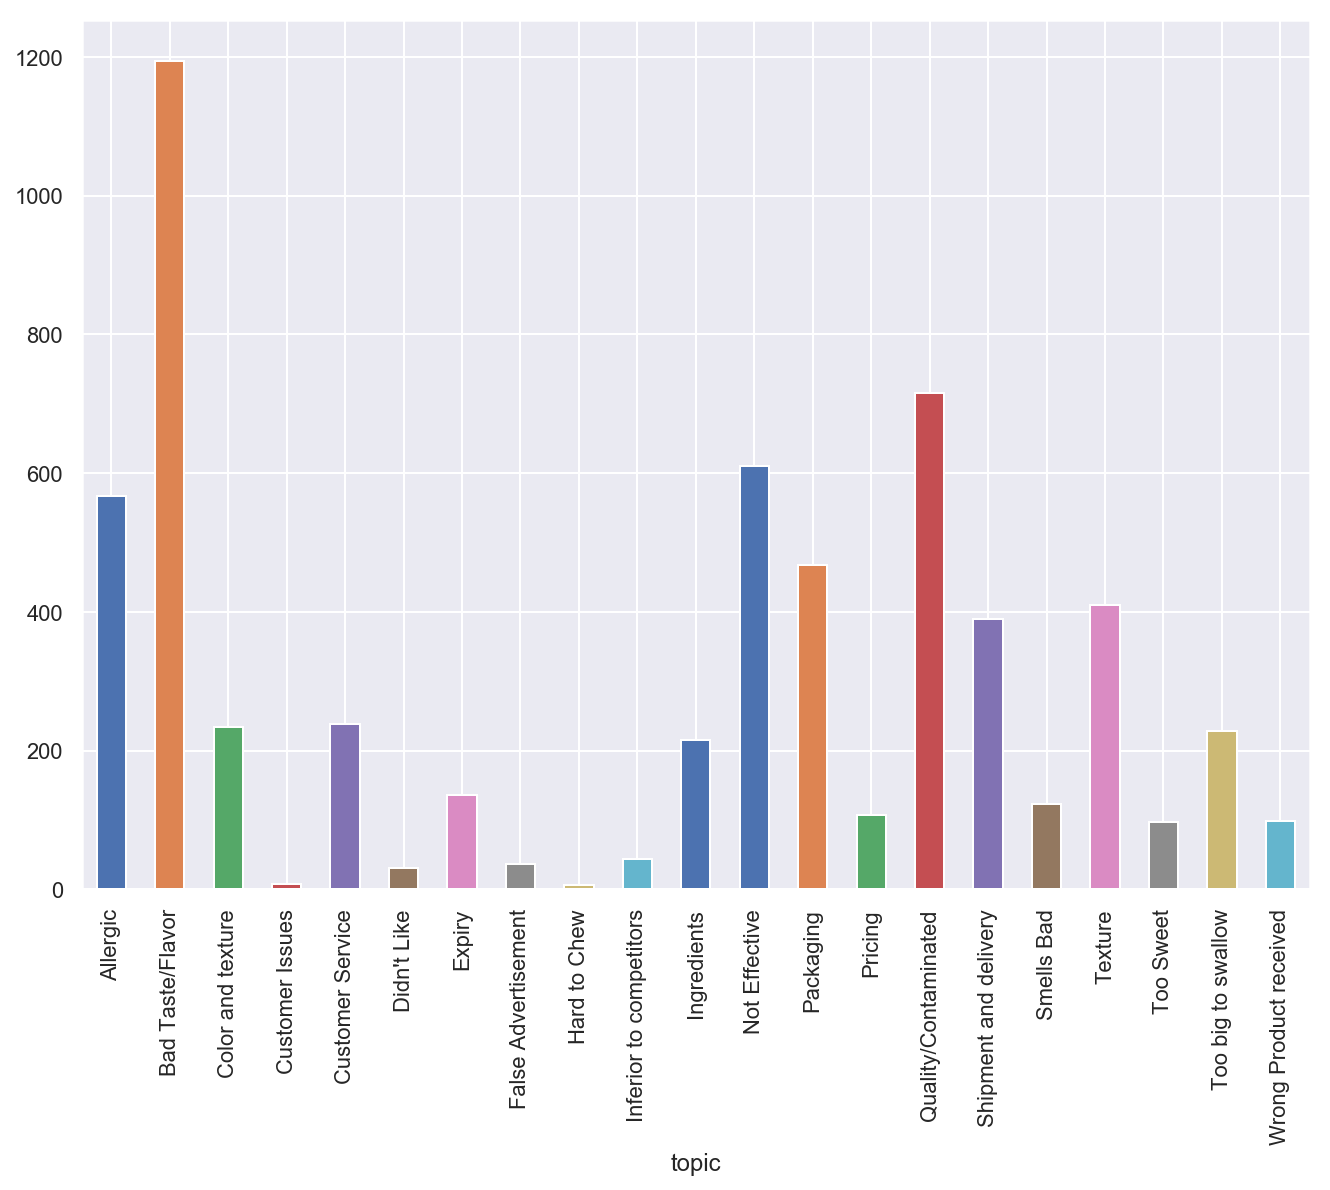

In [4]:
df_train.groupby("topic")['topic'].count().plot.bar()

### Inference: 

1. Some of the classes are highly imbalanced.
2. Most common class "Bad Taste/Flavor".
3. There are very few instances of reviews having "Customer Issues", "DIdn't Like", "False Advertisement", "Hard to chew" as Topics.

### [1.2]. Preprocessing Review Text

Preprocessing phase we do the following in the order below:-

- Begin by removing the html tags
- Remove any punctuations or limited set of special characters like , or . or # etc.
- Check if the word is made up of english letters and is not alpha-numeric
- Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
- Convert the word to lowercase
- Remove Stopwords
- Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
- After which we collect the words used to describe positive and negative reviews

In [5]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [7]:
# Create a Snowball stemmer 
#snowballstemmer = SnowballStemmer('english')
#porterStemmer = PorterStemmer()
lemma = WordNetLemmatizer()

def text_preprocessing(sentence):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    #To remove anything that is not alphabetic. We will repeat experiment with numeric features.
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # Removing stopwords and applying snowball stemmer.
    #sentence = ' '.join(stemmer.stem(e.lower()) for e in sentence.split() if e.lower() not in stopwords)
    #sentence = ' '.join(porterStemmer.stem(e.lower()) for e in sentence.split() if e.lower() not in stopwords)
    sentence = ' '.join(lemma.lemmatize(e.lower()) for e in sentence.split() if e.lower() not in stopwords)
    #sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    sentence = ' '.join(e.lower() for e in sentence.split())
    sentence = sentence.strip()
    return sentence

In [8]:
df_train['Preprocessed_Review_Text'] = df_train['Review Text'].apply(lambda x: text_preprocessing(x))
df_train['Preprocessed_Review_Title'] = df_train['Review Title'].apply(lambda x: text_preprocessing(x))

df_test['Preprocessed_Review_Text'] = df_test['Review Text'].apply(lambda x: text_preprocessing(x))
df_test['Preprocessed_Review_Title'] = df_test['Review Title'].apply(lambda x: text_preprocessing(x))

In [9]:
df_train.head()

,Review Text,Review Title,topic,Preprocessed_Review_Text,Preprocessed_Review_Title
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery,nothing not help lost even working eating heal...,useless
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective,nothing not help lost even working eating heal...,useless
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service,bought bag immediately open one put trash bag ...,trash not buy bag waist time
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic,gave allergic reaction face,not recommend
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture,not compare name brand wipe family little kid ...,ca not tackle big mess


In [10]:
df_test.head()

,Review Text,Review Title,Preprocessed_Review_Text,Preprocessed_Review_Title
0,I use chia seed in my protein shakes. These ta...,Bad tast,use chia seed protein shake tasted like moldy ...,bad tast
1,I use chia seed in my protein shakes. These ta...,Bad tast,use chia seed protein shake tasted like moldy ...,bad tast
2,Don’t waste your money.,No change. No results.,waste money,no change no result
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",use book fortify life tieraona low dog md help...,good vegan choice poor non vegan choice
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",use book fortify life tieraona low dog md help...,good vegan choice poor non vegan choice


### Inference: 

1. Some of the classes are highly imbalanced.
2. Most common class "Bad Taste/Flavor".
3. There are very few instances of reviews having "Customer Issues", "DIdn't Like", "False Advertisement", "Hard to chew" as Topics.

In [11]:
# Lets consider the most common class.
Bad_Taste_or_Flavor = df_train[df_train['topic']=='Bad Taste/Flavor']

In [12]:
freq1 = defaultdict(int)
tokenizer = RegexpTokenizer(r'\w+')
freq2 = defaultdict(int)

for each in Bad_Taste_or_Flavor['Preprocessed_Review_Text'].values:
    for token in tokenizer.tokenize(each):
        freq1[token] += 1
for each in Bad_Taste_or_Flavor['Preprocessed_Review_Title'].values:
    for token in tokenizer.tokenize(each):
        freq2[token] += 1

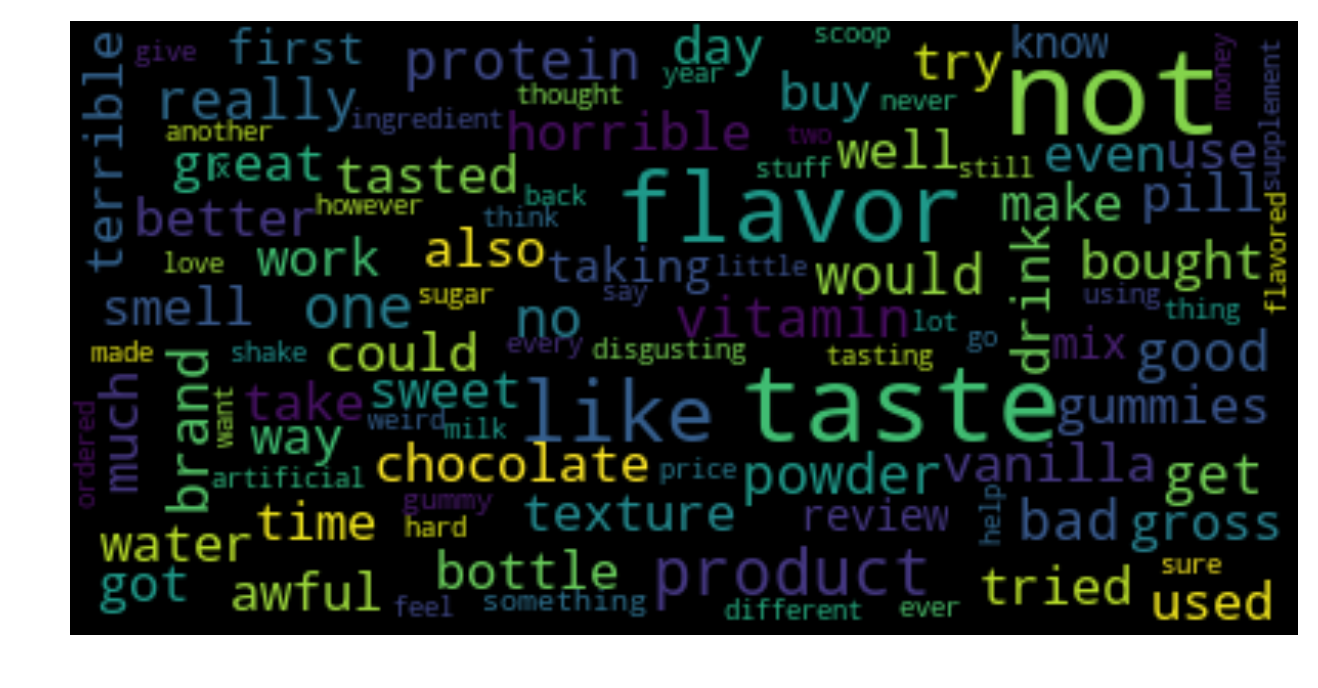

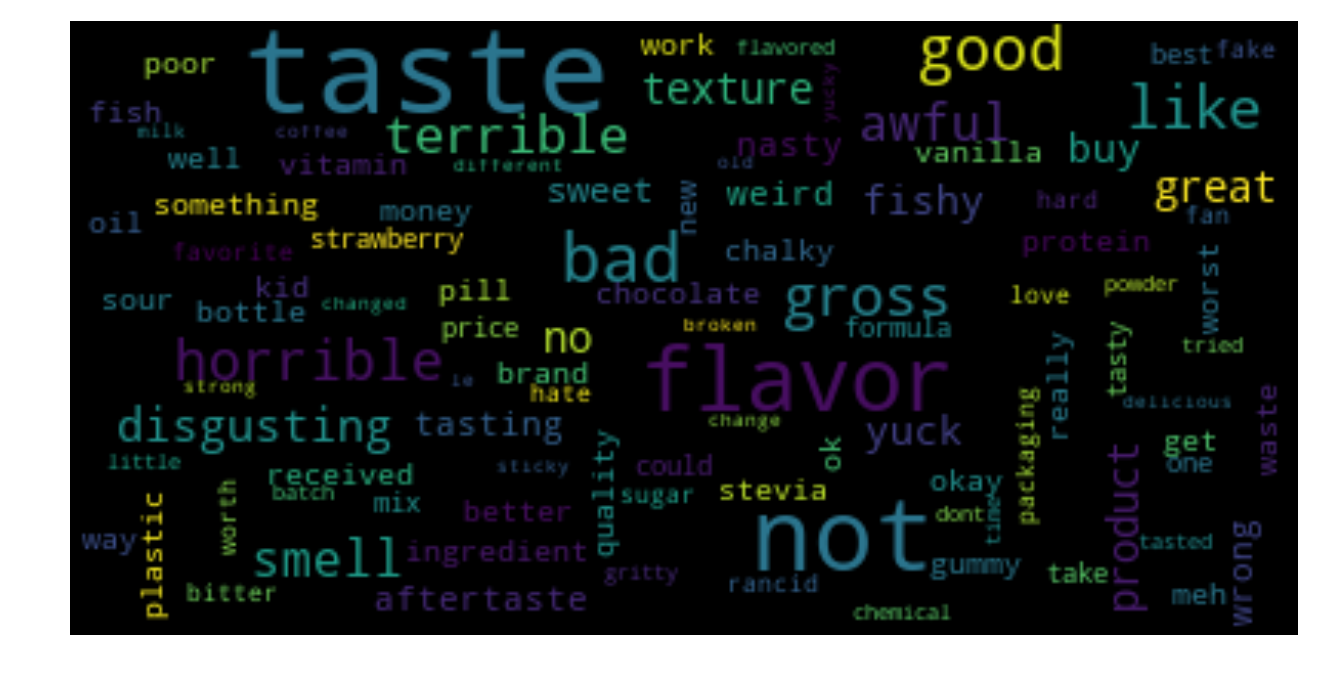

In [13]:
## Code Courtesy: WordCloud Documentation
stopwords= set(stopwords)
wordcloud = WordCloud(max_font_size=40, max_words=100, stopwords=None).generate_from_frequencies(freq1)#taking top 50 words.
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

stopwords= set(stopwords)
wordcloud = WordCloud(max_font_size=40, max_words=100, stopwords=None).generate_from_frequencies(freq2)#taking top 50 words.
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Inference:
- Words 'not', 'flavor', 'tast' seems to be most common words in both Review Text and Review Title.

In [14]:
# Lets consider the most common class.
Quality_or_Contaminated = df_train[df_train['topic']=='Quality/Contaminated']

In [15]:
freq1 = defaultdict(int)
tokenizer = RegexpTokenizer(r'\w+')
freq2 = defaultdict(int)

for word in Quality_or_Contaminated['Preprocessed_Review_Text'].values:
    for token in tokenizer.tokenize(word):
        freq1[token] += 1
for word in Quality_or_Contaminated['Preprocessed_Review_Title'].values:
    for token in tokenizer.tokenize(word):
        freq2[token] += 1

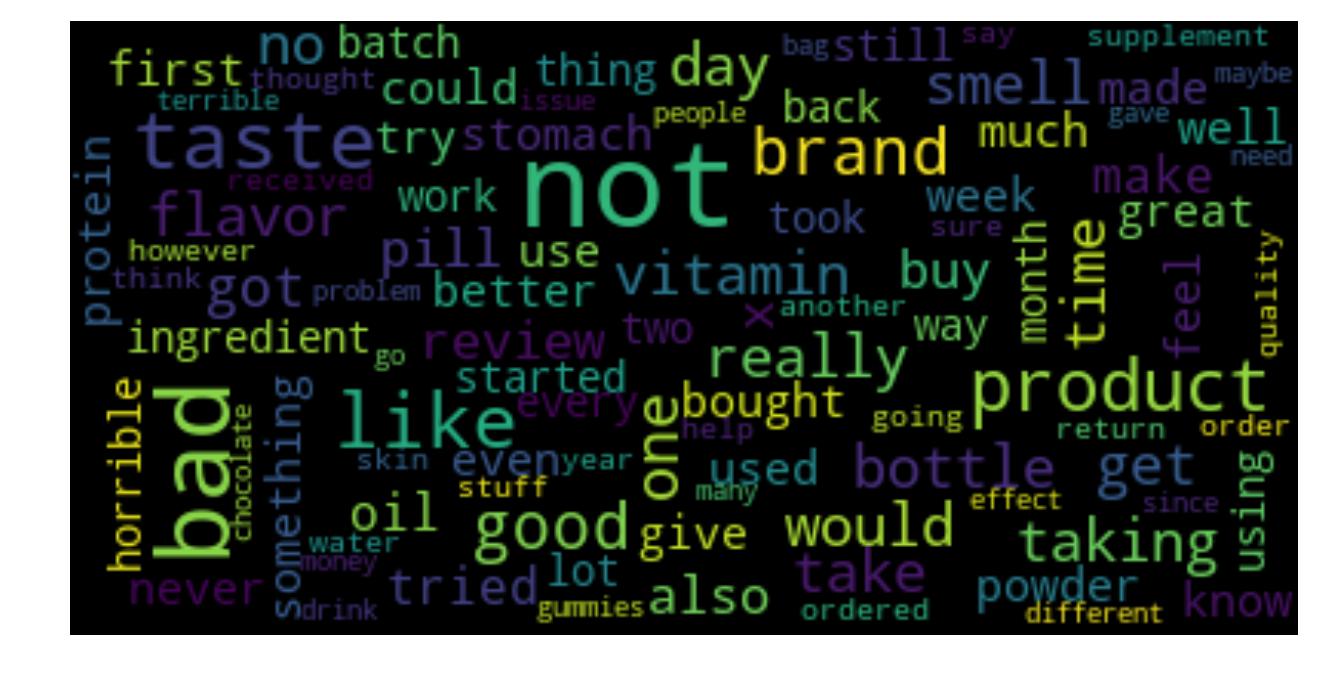

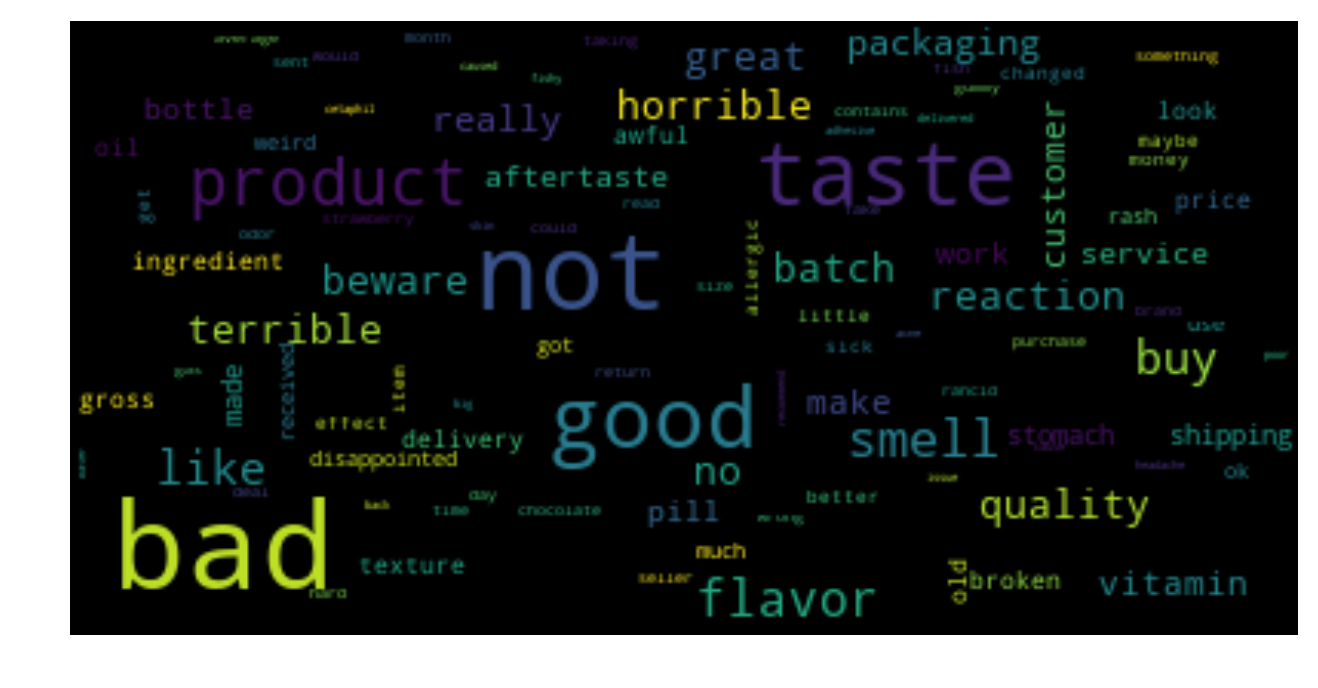

In [16]:
## Code Courtesy: WordCloud Documentation
stopwords= set(stopwords)
wordcloud = WordCloud(max_font_size=40, max_words=100, stopwords=None).generate_from_frequencies(freq1)#taking top 50 words.
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

stopwords= set(stopwords)
wordcloud = WordCloud(max_font_size=40, max_words=100, stopwords=None).generate_from_frequencies(freq2)#taking top 50 words.
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Inference:
- Words 'not', 'bad', 'product', 'taste' seems to be most common words both Review Text and Review Title.

In [17]:
# Lets consider the most common class.
Customer_Issues = df_train[df_train['topic']=='Customer Issues']

In [18]:
Customer_Issues['Review Text'].values[1]

'I have been waiting for almost a week after ordering and this product has not shipped? Tried to cancel and "X Brand" will not cancel. They say contact seller directly but no way to contact. Will contact credit card and order some where else next time.'

In [19]:
freq1 = defaultdict(int)
tokenizer = RegexpTokenizer(r'\w+')
freq2 = defaultdict(int)

for word in Customer_Issues['Preprocessed_Review_Text'].values:
    for token in tokenizer.tokenize(word):
        freq1[token] += 1
for word in Customer_Issues['Preprocessed_Review_Title'].values:
    for token in tokenizer.tokenize(word):
        freq2[token] += 1

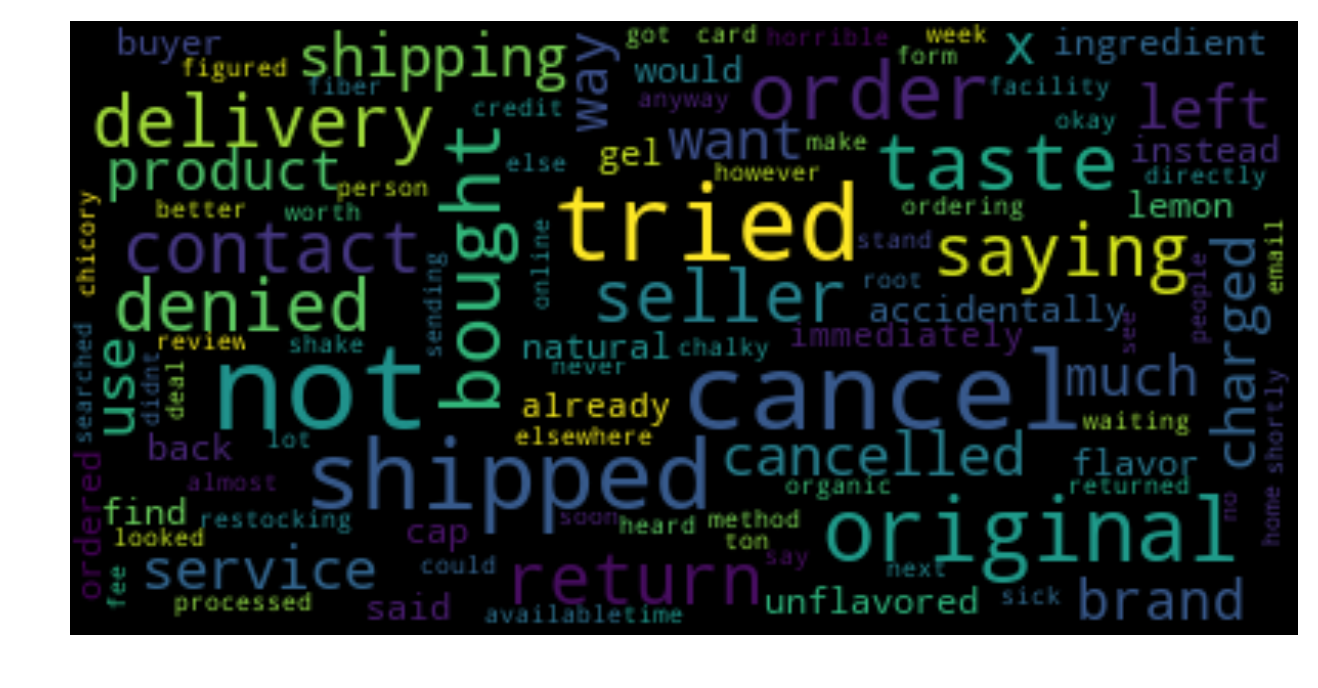

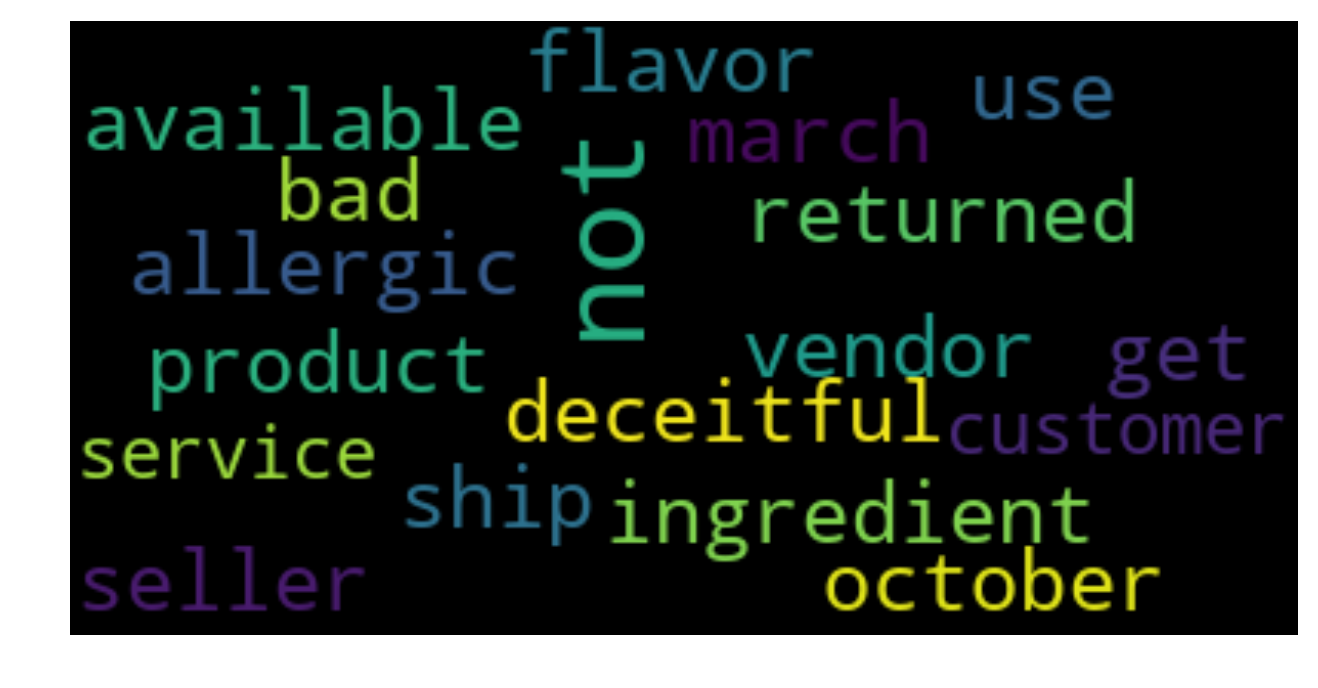

In [20]:
## Code Courtesy: WordCloud Documentation
stopwords= set(stopwords)
wordcloud = WordCloud(max_font_size=40, max_words=100, stopwords=None).generate_from_frequencies(freq1)#taking top 50 words.
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

stopwords= set(stopwords)
wordcloud = WordCloud(max_font_size=40, max_words=100, stopwords=None).generate_from_frequencies(freq2)#taking top 50 words.
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Inference:
- Words 'not', 'cancel', 'cancel', 'shipped' seems to be most common words.

+ We will be concatenating both the Review Text and Review Title and construct NLP features.

In [21]:
with open('df_train.pkl', 'wb') as fp:   #for saving a file into a pickle file.
    pickle.dump(df_train, fp)
with open('df_test.pkl', 'wb') as fp:   #for saving a file into a pickle file.
    pickle.dump(df_test, fp)